In [88]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
df = pd.read_csv('../data/250206-passthrough-chuc-4xA100-burn300.csv')
df = pd.read_csv('../data/250209-passthrough-chuc-4xA100-burn300-4states.csv')
df.reset_index(inplace=True)

drop_everything_before_measure = 'idle'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        focus = df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure')
        focus.reset_index(inplace=True)
        pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
        frames.append(pd.concat([pivot, focus], axis=1))
    range_start = range_end
focus = df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure')
focus.reset_index(inplace=True)
pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
frames.append(pd.concat([pivot, focus], axis=1))

dataset = pd.concat(frames)
dataset.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
dataset = dataset.astype({key:'float' for key in dataset_keys})
dataset.reset_index(inplace=True)

/tmp/ipykernel_18693/3568767760.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_18693/3568767760.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset.reset_index(inplace=True)
/tmp/ipykernel_18693/3568767760.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfr

In [4]:
dataset = dataset.drop(dataset.loc[dataset['timestamp'] > 280 ].index)
dataset = dataset.drop(dataset.loc[dataset['timestamp'] < 30 ].index)

# Graph time : multi usage level example (0, 33, 66, 100)

In [90]:
dataset['CONST_context'].unique()[:20]

array(['2|0|0|0', '4|0|0|0', '7|0|0|0', '0|2|0|0', '2|2|0|0', '4|2|0|0',
       '7|2|0|0', '0|4|0|0', '2|4|0|0', '4|4|0|0', '7|4|0|0', '0|7|0|0',
       '2|7|0|0', '4|7|0|0', '7|7|0|0', '0|0|2|0', '2|0|2|0', '4|0|2|0',
       '7|0|2|0', '0|2|2|0'], dtype=object)

In [91]:
sns.color_palette("Set2")
sns.set_theme(style="white")

In [100]:
ipmi_keys = [key for key in dataset_keys if 'IPMI' in key]
domain = ['GPU0', 'GPU1', 'GPU2', 'GPU3']
domain_ipmi_keys = domain + ipmi_keys
timestamp_ipmi_keys = ['timestamp'] + domain_ipmi_keys

corr = dataset[domain_ipmi_keys].corr(method = 'pearson')
corr_filtered = corr[:len(domain)][ipmi_keys].T.dropna()

Correlation between IPMI and GPU temp

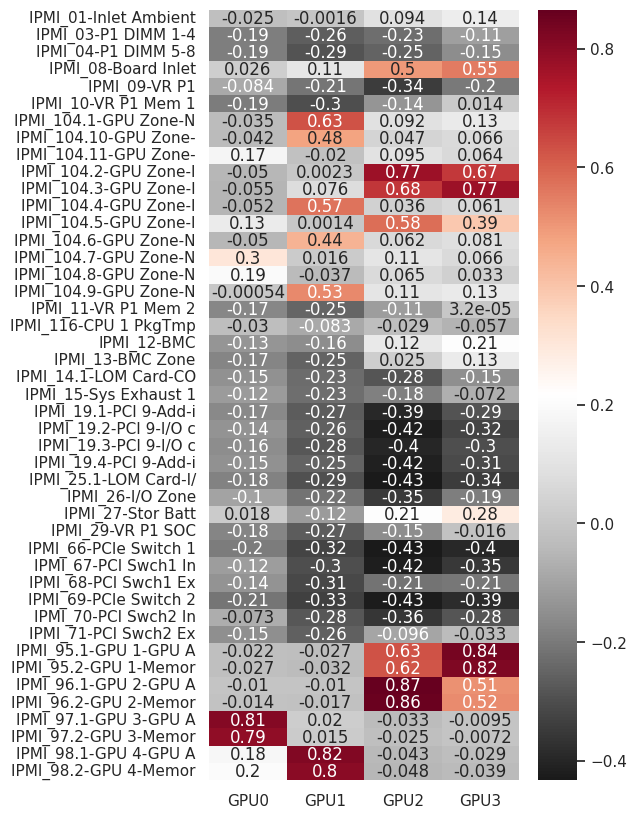

In [102]:
fig, ax = plt.subplots(figsize=(5, 10))  # Set the figure size

sns.heatmap(corr_filtered, ax=ax, annot = True, cmap=sns.color_palette(palette='RdGy_r', as_cmap=True))

plt.gcf().savefig('figures/pearson-corr-ipmi.pdf', bbox_inches='tight')

In [9]:
ipmi_correlation = {}
for gpu in domain:
    ipmi_correlation[gpu] = corr_filtered[gpu].idxmax()
    print('For', gpu, 'selecting', ipmi_correlation[gpu])

def attach_sensor_value(row):
    if row['domain'] not in ipmi_correlation.keys(): return None
    return dataset[(dataset["timestamp"] == row["timestamp"]) & (dataset["CONST_context"] == row["CONST_context"]) & (dataset["domain"] == "GPU-X")][ipmi_correlation[row["domain"]]].values[0]
    
dataset['sensor'] = dataset.apply(lambda row : attach_sensor_value(row), axis=1)
dataset_domains = dataset.loc[dataset['domain'].isin(ipmi_correlation.keys())]

dataset_domains = dataset.drop(dataset.loc[dataset['domain'].isin(['GPU-X', 'global'])].index)
dataset_domains['compute'] = dataset_domains.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)

For GPU0 selecting IPMI_97.1-GPU 3-GPU A
For GPU1 selecting IPMI_98.1-GPU 4-GPU A
For GPU2 selecting IPMI_104.2-GPU Zone-I
For GPU3 selecting IPMI_95.1-GPU 1-GPU A


/tmp/ipykernel_18693/4213839810.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['sensor'] = dataset.apply(lambda row : attach_sensor_value(row), axis=1)
/tmp/ipykernel_18693/4213839810.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset_domains['compute'] = dataset_domains.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)


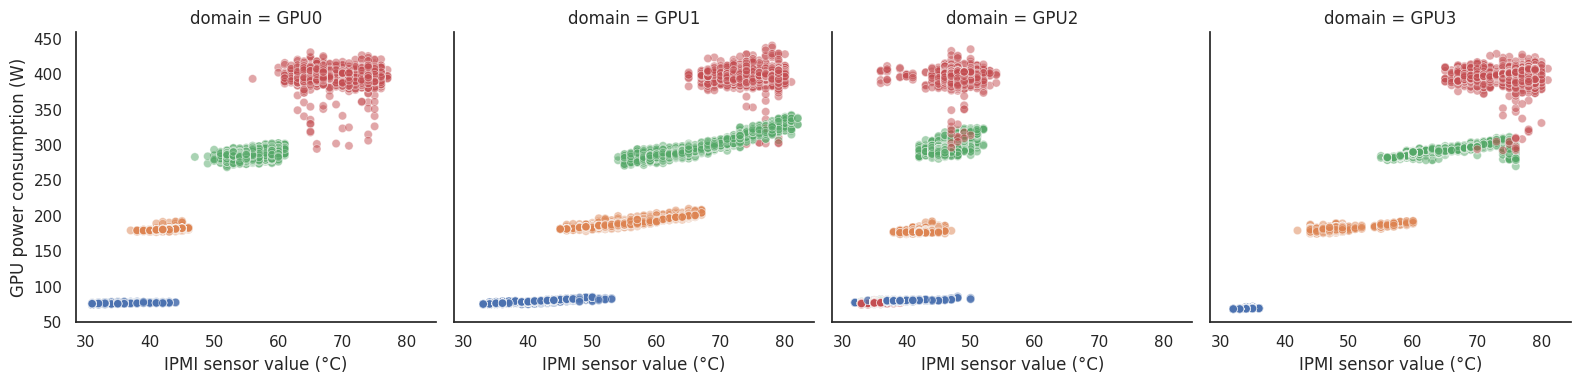

In [54]:
# SMI_temperature.gpu
# SMI_utilization.gpu
g = sns.relplot(
    data=dataset_domains, x="sensor", y="SMI_power.draw",
    hue="compute", col="domain", col_order=['GPU0','GPU1','GPU2','GPU3'], height=4, alpha=0.5
)

g.set_axis_labels("IPMI sensor value (°C)", "GPU power consumption (W)")
g._legend.remove()
plt.gcf().savefig('figures/combination-ci-ipmi.pdf', bbox_inches='tight')

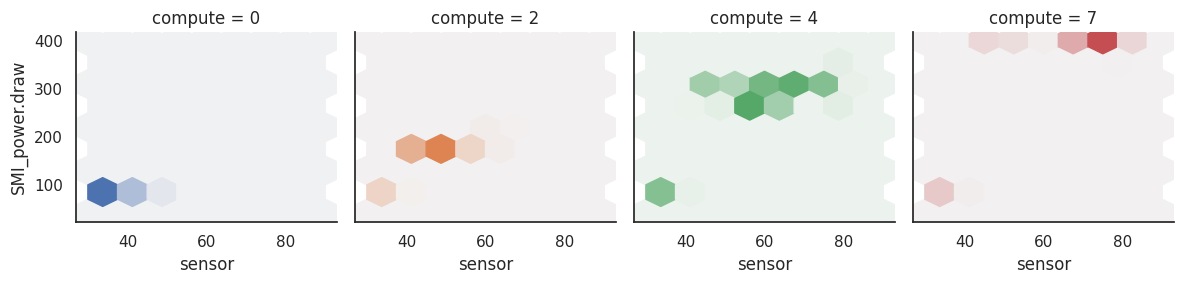

In [105]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=8, cmap=cmap, **kwargs)

g = sns.FacetGrid(dataset_domains, col="compute", hue='compute')
g.map(hexbin, "sensor", "SMI_power.draw", extent=[30, 90, 40, 400])

Axes(0.125,0.11;0.775x0.77)


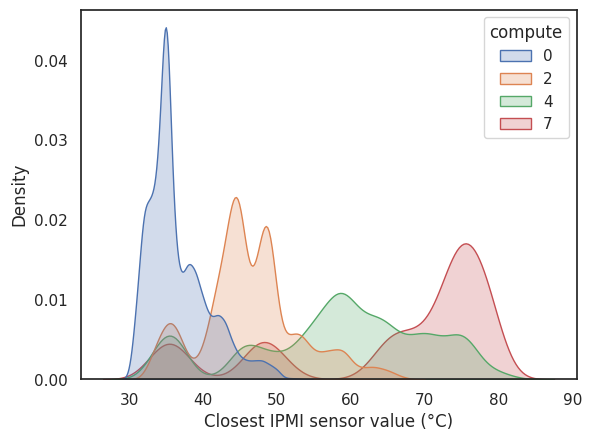

In [103]:
g = sns.kdeplot(dataset_domains, x="sensor", hue="compute", fill=True)
g.set(xlabel='Closest IPMI sensor value (°C)', ylabel='Density')
print(g)
plt.gcf().savefig('figures/combination-ci-ipmi-density.pdf', bbox_inches='tight')

Now, trying to improve by identifying neighbour

In [222]:
corr_neighbour = dataset[ipmi_correlation.values()].dropna().corr(method = 'spearman').rename(dict((v,k) for k,v in ipmi_correlation.items())).rename(dict((v,k) for k,v in ipmi_correlation.items()), axis=1)

neighbour = {}
for gpu in domain:
    neighbour_gpu = corr_neighbour[corr_neighbour.index != gpu][gpu].idxmax()
    neighbour[gpu] = ipmi_correlation[neighbour_gpu]
    print('For', gpu, 'neighbour might be', neighbour_gpu)

def attach_neighbour_value(row):
    if row['domain'] not in neighbour.keys(): return None
    return dataset[(dataset["timestamp"] == row["timestamp"]) & (dataset["CONST_context"] == row["CONST_context"]) & (dataset["domain"] == "GPU-X")][neighbour[row["domain"]]].values[0]
    
dataset['neighbour'] = dataset.apply(lambda row : attach_neighbour_value(row), axis=1)
dataset_domains = dataset.loc[dataset['domain'].isin(neighbour.keys())]
dataset_domains['neighbour_delta'] = dataset_domains.apply(lambda row : row['neighbour'] - dataset[neighbour[row["domain"]]].min(), axis=1)
dataset_domains['compute'] = dataset_domains.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)

For GPU0 neighbour might be GPU1
For GPU1 neighbour might be GPU0
For GPU2 neighbour might be GPU3
For GPU3 neighbour might be GPU2


/tmp/ipykernel_10926/1942695894.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['neighbour'] = dataset.apply(lambda row : attach_neighbour_value(row), axis=1)


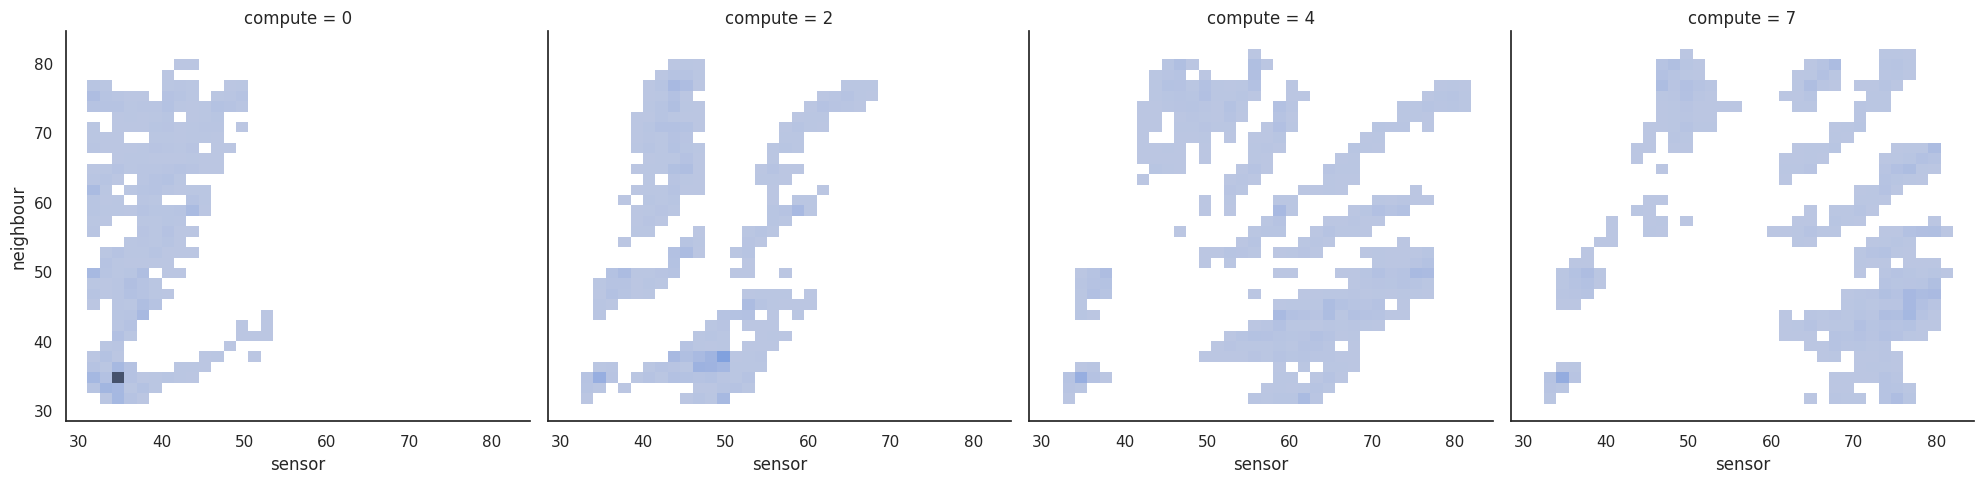

In [244]:
g = sns.displot(dataset_domains, x="sensor", y='neighbour', col="compute", kind="hist")

In [245]:
#dataset_domains['sensor_corrected'] = dataset_domains.apply(lambda row : row['sensor'] - 10 if row['neighbour']>50 else row['sensor'], axis=1)
#g = sns.kdeplot(dataset_domains, x="sensor_corrected", hue="compute", fill=True)

# Graph time : High density example (8xA100)

In [261]:
df = pd.read_csv('../data/250209-passthrough-sirius-8xA100-burn300-2states.csv')
df.reset_index(inplace=True)

#df = df.drop(df.loc[df['measure'] == 'No' ].index)
drop_everything_before_measure = 'idle'

timestamp_decrease = df.timestamp.diff() < 0
restart = timestamp_decrease[timestamp_decrease].index.values
range_start = df.loc[df['measure'] == drop_everything_before_measure].iloc[0].values[0].astype(int)
frames = []
for range_end in restart:
    if range_start>0:
        range_start = df[range_start:range_end].loc[(df[range_start:range_end]['timestamp'] == 0) & (df[range_start:range_end]['domain'] == 'global')  & (df[range_start:range_end]['metric'] == 'CONST_context')].iloc[-1].values[0].astype(int)
        focus = df[range_start:range_end].pivot(index=['timestamp','domain'], columns='metric', values='measure')
        focus.reset_index(inplace=True)
        pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
        frames.append(pd.concat([pivot, focus], axis=1))
    range_start = range_end
focus = df[range_start:].pivot(index=['timestamp','domain'], columns='metric', values='measure')
focus.reset_index(inplace=True)
pivot = focus.pivot(index='timestamp', columns='domain', values='SMI_power.draw')
frames.append(pd.concat([pivot, focus], axis=1))

dataset2 = pd.concat(frames)
dataset2.set_index(['timestamp','domain', 'CONST_context'], inplace=True)
dataset_keys = list(dataset2.keys())
if 'SMI_PSTATE' in dataset_keys: dataset_keys.remove('SMI_PSTATE')
if 'SMI_pstate' in dataset_keys: dataset_keys.remove('SMI_pstate')
for key in dataset_keys:
    dataset2[key] = dataset2[key].replace('No', None)
    dataset2 = dataset2.astype({key:'float'})
dataset2.reset_index(inplace=True)
dataset2 = dataset2[dataset2['CONST_context'].notna()]

/tmp/ipykernel_10926/2766025773.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset2.reset_index(inplace=True)
/tmp/ipykernel_10926/2766025773.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset2.reset_index(inplace=True)
/tmp/ipykernel_10926/2766025773.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

In [252]:
dataset2 = dataset2.drop(dataset2.loc[dataset2['timestamp'] > 280 ].index)
dataset2 = dataset2.drop(dataset2.loc[dataset2['timestamp'] < 30 ].index)

In [87]:
ipmi_keys = [key for key in dataset_keys if 'IPMI' in key]
domain = ['GPU0', 'GPU1', 'GPU2', 'GPU3', 'GPU4', 'GPU5', 'GPU6', 'GPU7']
domain_ipmi_keys = domain + ipmi_keys
timestamp_ipmi_keys = ['timestamp'] + domain_ipmi_keys

corr2 = dataset2[domain_ipmi_keys].corr(method = 'pearson')
corr_filtered2 = corr2[:len(domain)][ipmi_keys].T.dropna()

NameError: name 'dataset2' is not defined

In [254]:
ipmi_correlation = {}
for gpu in domain:
    ipmi_correlation[gpu] = corr_filtered2[gpu].idxmax()
    print('For', gpu, 'selecting', ipmi_correlation[gpu])

def attach_sensor_value(row):
    if row['domain'] not in ipmi_correlation.keys(): return None
    return dataset2[(dataset2["timestamp"] == row["timestamp"]) & (dataset2["CONST_context"] == row["CONST_context"]) & (dataset2["domain"] == "GPU-X")][ipmi_correlation[row["domain"]]].values[0]
    
dataset2['sensor'] = dataset2.apply(lambda row : attach_sensor_value(row), axis=1)
dataset_domains2 = dataset2.loc[dataset2['domain'].isin(ipmi_correlation.keys())]

dataset_domains2 = dataset2.drop(dataset2.loc[dataset2['domain'].isin(['GPU-X', 'global'])].index)
dataset_domains2['compute'] = dataset_domains2.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)

For GPU0 selecting IPMI_TEMP_GB_GPU4_M
For GPU1 selecting IPMI_TEMP_GB_GPU7
For GPU2 selecting IPMI_TEMP_GB_GPU0
For GPU3 selecting IPMI_TEMP_GB_GPU3
For GPU4 selecting IPMI_TEMP_GB_GPU6_M
For GPU5 selecting IPMI_TEMP_GB_GPU5
For GPU6 selecting IPMI_TEMP_GB_GPU2
For GPU7 selecting IPMI_TEMP_GB_GPU1


/tmp/ipykernel_10926/1362091013.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset2['sensor'] = dataset2.apply(lambda row : attach_sensor_value(row), axis=1)
/tmp/ipykernel_10926/1362091013.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset_domains2['compute'] = dataset_domains2.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)


In [117]:
dataset_domains2['CONST_context']

1        7|0|0|0|0|0|0|0
2        7|0|0|0|0|0|0|0
6        7|0|0|0|0|0|0|0
37       7|0|0|0|0|0|0|0
38       7|0|0|0|0|0|0|0
              ...       
46342    7|7|7|7|7|7|7|7
46343    7|7|7|7|7|7|7|7
46344    7|7|7|7|7|7|7|7
46345    7|7|7|7|7|7|7|7
46346    7|7|7|7|7|7|7|7
Name: CONST_context, Length: 25200, dtype: object

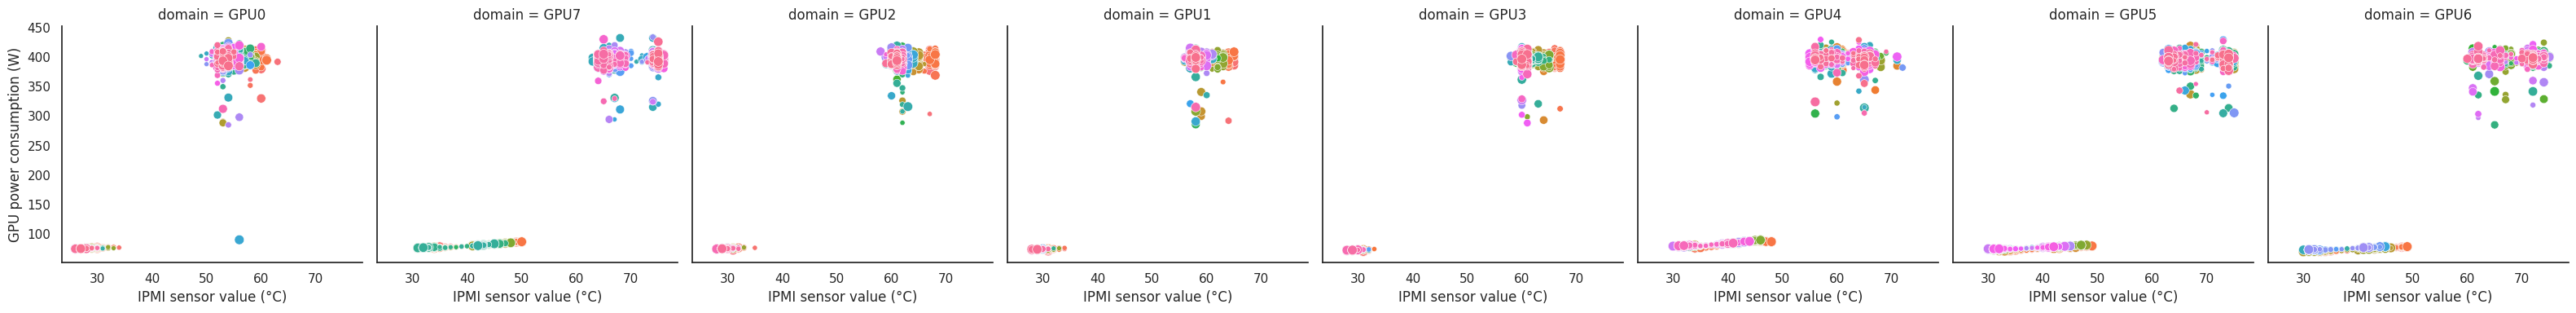

In [118]:
# SMI_temperature.gpu
# SMI_utilization.gpu
g = sns.relplot(
    data=dataset_domains2, x="sensor", y="SMI_power.draw",
    hue="CONST_context", col="domain", height=4, size="timestamp"
)
g.set_axis_labels("IPMI sensor value (°C)", "GPU power consumption (W)")
g._legend.remove()
plt.gcf().savefig('figures/combination-ci-ipmi-8GPU.pdf', bbox_inches='tight')

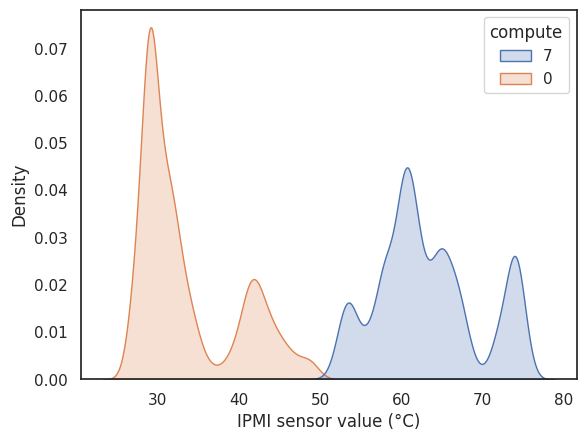

In [119]:
g = sns.kdeplot(dataset_domains2, x="sensor", hue="compute", fill=True)
g.set(xlabel='Closest IPMI sensor value (°C)', ylabel='Density')
plt.gcf().savefig('figures/combination-ci-ipmi-density-8GPU.pdf', bbox_inches='tight')

Identifying neighbour

In [258]:
corr_neighbour = dataset2[ipmi_correlation.values()].dropna().corr(method = 'spearman').rename(dict((v,k) for k,v in ipmi_correlation.items())).rename(dict((v,k) for k,v in ipmi_correlation.items()), axis=1)

neighbour = {}
for gpu in domain:
    neighbour_gpu = corr_neighbour[corr_neighbour.index != gpu][gpu].idxmax()
    neighbour[gpu] = ipmi_correlation[neighbour_gpu]
    print('For', gpu, 'neighbour might be', neighbour_gpu)

def attach_neighbour_value(row):
    if row['domain'] not in neighbour.keys(): return None
    return dataset2[(dataset2["timestamp"] == row["timestamp"]) & (dataset2["CONST_context"] == row["CONST_context"]) & (dataset2["domain"] == "GPU-X")][neighbour[row["domain"]]].values[0]
    
dataset2['neighbour'] = dataset2.apply(lambda row : attach_neighbour_value(row), axis=1)
dataset_domains2 = dataset2.loc[dataset2['domain'].isin(neighbour.keys())]
dataset_domains2['neighbour_delta'] = dataset_domains2.apply(lambda row : row['neighbour'] - dataset_domains2[neighbour[row["domain"]]].min(), axis=1)
dataset_domains2['compute'] = dataset_domains2.apply(lambda x : x['CONST_context'].split('|')[int(x['domain'].replace("GPU", ""))], axis=1)

For GPU0 neighbour might be GPU4
For GPU1 neighbour might be GPU5
For GPU2 neighbour might be GPU6
For GPU3 neighbour might be GPU7
For GPU4 neighbour might be GPU0
For GPU5 neighbour might be GPU1
For GPU6 neighbour might be GPU2
For GPU7 neighbour might be GPU3


/tmp/ipykernel_10926/2246141411.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset2['neighbour'] = dataset2.apply(lambda row : attach_neighbour_value(row), axis=1)
/tmp/ipykernel_10926/2246141411.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset_domains2['neighbour_delta'] = dataset_domains2.apply(lambda row : row['neighbour'] - dataset_domains2[neighbour[row["domain"]]].min(), axis=1)
/tmp/ipykernel_10926/2246141411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

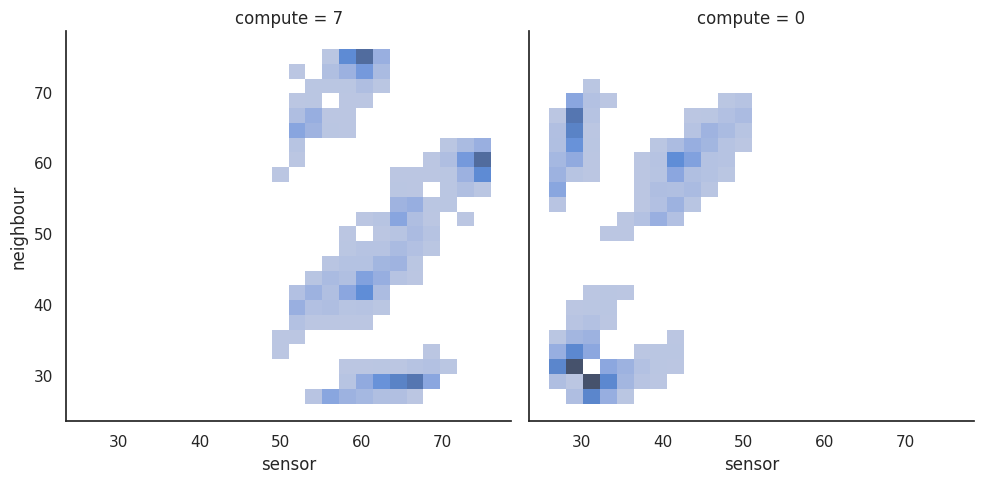

In [259]:
g = sns.displot(dataset_domains2, x="sensor", y='neighbour', col="compute", kind="hist")